In [59]:
import ipywidgets as widgets
import pandas as pd
import numpy as np
import seaborn as sns
import pycountry
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import IPython 
import IPython.display as display
%matplotlib inline

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style('darkgrid')
sns.set_palette('colorblind')

In [11]:
LATEST_CASES_PATH_CSV = 'data/cases-per-day.csv'
LATEST_CASES_PATH_XLSX = 'data/cases-per-day.xlsx'

In [12]:
df = pd.read_excel(LATEST_CASES_PATH_XLSX, parse_dates=[0], encoding='iso-8859-1', index_col=0).rename(
    columns={
        'dateRep': 'date', 
        'countriesAndTerritories': 'geo_name', 
        'geoId': 'geo_id',
        'popData2018': 'pop_data_2018'
    },
    index={'dateRep': 'date'}
)
df.index.names = ['date']
df = df.drop(columns=['day', 'month', 'year', 'countryterritoryCode'])
df['geo_name'] = df['geo_name'].apply(lambda s: s.replace('_', ' '))

df

,cases,deaths,geo_name,geo_id,pop_data_2018
date,,,,,
2020-03-31,27,0,Afghanistan,AF,37172386.0
2020-03-30,8,1,Afghanistan,AF,37172386.0
2020-03-29,15,1,Afghanistan,AF,37172386.0
2020-03-28,16,1,Afghanistan,AF,37172386.0
2020-03-27,0,0,Afghanistan,AF,37172386.0
...,...,...,...,...,...
2020-03-25,0,0,Zimbabwe,ZW,14439018.0
2020-03-24,0,1,Zimbabwe,ZW,14439018.0
2020-03-23,0,0,Zimbabwe,ZW,14439018.0


In [13]:
lockdowns_raw = [
    ['2020-03-23', 'UK'],
    ['2020-03-01', 'IT'],
    ['2020-03-08', 'IT'],

]
lockdowns = pd.DataFrame(np.array(lockdowns_raw), columns=['lockdown_date', 'country_code'])
lockdowns['lockdown_date'] = lockdowns['lockdown_date'].apply(lambda d: np.datetime64(d))

lockdowns.set_index('lockdown_date', inplace=True)

lockdowns

,country_code
lockdown_date,
2020-03-23,UK
2020-03-01,IT
2020-03-08,IT


In [14]:
def rank_index(df):
    new_df = df.reset_index()
    new_df.index += 1
    
    return new_df.drop(columns=['index'])

In [15]:
aggregated = df.groupby(['geo_id', 'pop_data_2018', 'geo_name'], as_index=False)[['cases', 'deaths']].sum()

aggregated['cases_per_100k'] = aggregated['cases'] / (aggregated['pop_data_2018'] / 10 ** 5)
aggregated['deaths_per_100k'] = aggregated['deaths'] / (aggregated['pop_data_2018'] / 10 ** 5)
aggregated = aggregated.sort_values(by=['cases_per_100k'], ascending=False)
aggregated = rank_index(aggregated)

aggregated

,geo_id,pop_data_2018,geo_name,cases,deaths,cases_per_100k,deaths_per_100k
1,JPG11668,3000.0,Cases on an international conveyance Japan,696,7,23200.000000,233.333333
2,SM,33785.0,San Marino,229,25,677.815599,73.997336
3,VA,1000.0,Holy See,6,0,600.000000,0.000000
4,AD,77006.0,Andorra,370,8,480.482040,10.388801
5,FO,48497.0,Faroe Islands,168,0,346.413180,0.000000
...,...,...,...,...,...,...,...
191,SO,15008154.0,Somalia,3,0,0.019989,0.000000
192,NP,28087871.0,Nepal,5,0,0.017801,0.000000
193,SD,41801533.0,Sudan,6,2,0.014354,0.004785
194,PG,8606316.0,Papua New Guinea,1,0,0.011619,0.000000


In [36]:
def make_per_100k_over_time(column, threshold):
    cum_column = f"cum_{column}"
    cum_100k_column = f"{column}_per_100k"
    
    def fn(country_code, df, threshold=threshold):
        cdf = df[(df['geo_id'] == country_code)]
        cdf = cdf.sort_index(ascending=True)
        cdf[cum_column] = cdf[column].cumsum()
        cdf[cum_100k_column] = cdf[cum_column] / (cdf['pop_data_2018'] / 10 ** 5)

        cdf = cdf[cdf[cum_column] > threshold]
        cdf = cdf.reset_index()

        return cdf
    
    return fn

cases_per_100k_over_time = make_per_100k_over_time('cases', 500)
deaths_per_100k_over_time = make_per_100k_over_time('deaths', 10)

## Confirmed Cases

In [17]:
# Only consider countries with at least 1m citizens
larger_countries_cases_per_100k = aggregated[aggregated['pop_data_2018'] >= 10 ** 6]
larger_countries_cases_per_100k = larger_countries_cases_per_100k.sort_values(by=['cases_per_100k'], ascending=False)
larger_countries_cases_per_100k = rank_index(larger_countries_cases_per_100k)

larger_countries_cases_per_100k[['geo_name', 'cases_per_100k', 'cases', 'pop_data_2018']].head(60)

,geo_name,cases_per_100k,cases,pop_data_2018
1,Spain,182.337680,85195,4.672375e+07
2,Switzerland,180.965446,15412,8.516543e+06
3,Italy,168.354857,101739,6.043128e+07
4,Austria,108.714364,9618,8.847037e+06
5,Belgium,104.175531,11899,1.142207e+07
6,Norway,79.520753,4226,5.314336e+06
7,Germany,74.658810,61913,8.292792e+07
8,Netherlands,68.190984,11750,1.723102e+07
9,France,66.505199,44550,6.698724e+07
10,Portugal,62.323948,6408,1.028176e+07


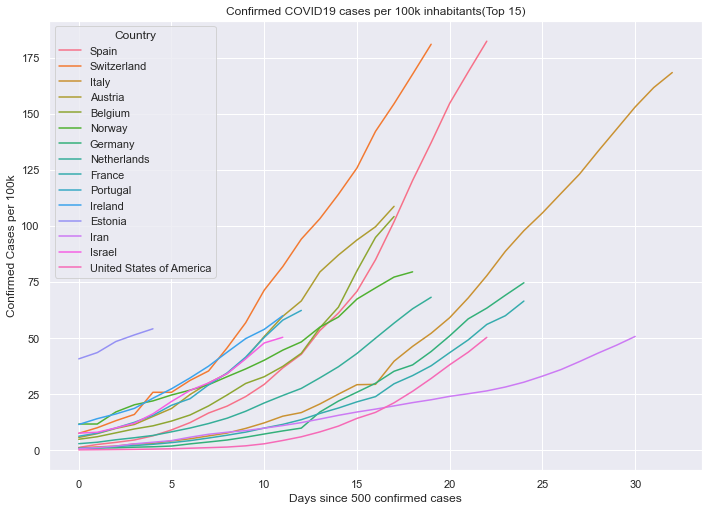

In [18]:
countries = larger_countries_cases_per_100k['geo_id'].head(15)
frames = [cases_per_100k_over_time(country, df) for country in countries]
plot_df = pd.concat(frames)

ax = sns.lineplot(
    x=plot_df.index, 
    y='cases_per_100k',
    hue='geo_name',
    legend='full',
    data=plot_df
)
ax.set(title='Confirmed COVID19 cases per 100k inhabitants(Top 15)')
ax.set(xlabel='Days since 500 confirmed cases')
ax.set(ylabel='Confirmed Cases per 100k')
labels = ax.get_legend().get_texts()
ax.legend(title='Country', loc='best', labels=[label.get_text() for label in labels[1:]])

plt.show()

In [93]:
@widgets.interact(
    country_code=widgets.Dropdown(
        options=[(name, geo_id) for (name, geo_id) in aggregated[['geo_name', 'geo_id']].to_records(index=False)],
        value='US',
        description='Country:',
    ),
    threshold=widgets.IntSlider(min=0, max=1000, step=1, value=500)
)
def plot(country_code, threshold=500):
    code = country_code
    lockdowns_for_country = lockdowns[lockdowns['country_code'] == code]
    country = cases_per_100k_over_time(code, df, threshold).set_index('date').join(lockdowns_for_country).reset_index()
    if country.empty:
        display.display(display.Markdown('# No Data for the selected filters'))
        return
    
    lockdown_days = country.index[country['country_code'] == code].to_list()
    country_name = country.iloc[0]['geo_name']

    ax = sns.lineplot(
        x=country.index, 
        y='cases_per_100k',
        legend='full',
        data=country
    )

    if len(lockdown_days) > 0:
        for lockdown_day in lockdown_days: 
            ax.axvline(lockdown_day, label="Lockdown", alpha=0.5, color='r', linestyle='--')

    ax.set(title=f"Confirmed COVID19 cases per 100k inhabitants({country_name})")
    ax.set(xlabel=f"Days since {threshold} confirmed cases")
    ax.set(ylabel='Confirmed Cases per 100k')
    plt.show()


interactive(children=(Dropdown(description='Country:', index=27, options=(('Cases on an international conveyan…

## Deaths

In [20]:
# Only consider countries with at least 1m citizens
larger_countries_deaths_per_100k = aggregated[aggregated['pop_data_2018'] >= 10 ** 6]
larger_countries_deaths_per_100k = larger_countries_deaths_per_100k.sort_values(by=['deaths_per_100k'], ascending=False)
larger_countries_deaths_per_100k = rank_index(larger_countries_deaths_per_100k)

larger_countries_deaths_per_100k[['geo_name', 'deaths_per_100k', 'deaths', 'pop_data_2018']].head(60)

,geo_name,deaths_per_100k,deaths,pop_data_2018
1,Italy,19.180463,11591,6.043128e+07
2,Spain,15.709356,7340,4.672375e+07
3,Netherlands,5.014214,864,1.723102e+07
4,France,4.514292,3024,6.698724e+07
5,Belgium,4.491306,513,1.142207e+07
6,Switzerland,3.463847,295,8.516543e+06
7,Iran,3.370405,2757,8.180027e+07
8,United Kingdom,2.117644,1408,6.648899e+07
9,Sweden,1.433738,146,1.018318e+07
10,Portugal,1.361634,140,1.028176e+07


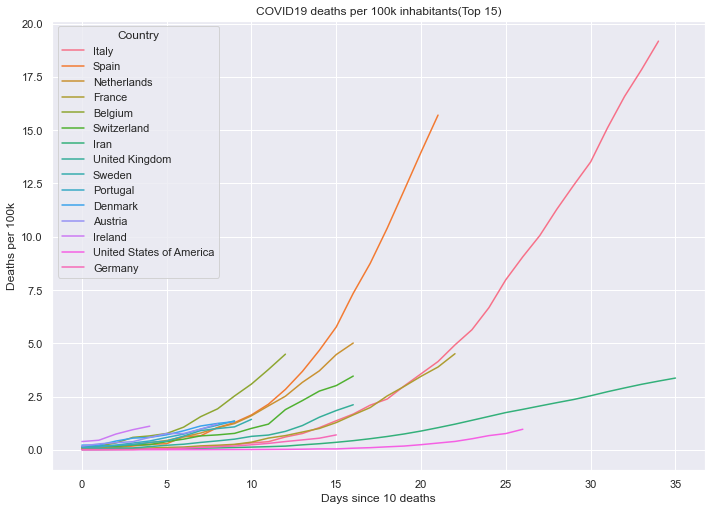

In [21]:
countries = larger_countries_deaths_per_100k['geo_id'].head(15)
frames = [deaths_per_100k_over_time(country, df) for country in countries]
plot_df = pd.concat(frames)

ax = sns.lineplot(
    x=plot_df.index, 
    y='deaths_per_100k',
    hue='geo_name',
    legend='full',
    data=plot_df
)
ax.set(title='COVID19 deaths per 100k inhabitants(Top 15)')
ax.set(xlabel='Days since 10 deaths')
ax.set(ylabel='Deaths per 100k')
labels = ax.get_legend().get_texts()
ax.legend(title='Country', loc='best', labels=[label.get_text() for label in labels[1:]])
pplt.show()

In [92]:
@widgets.interact(
    country_code=widgets.Dropdown(
        options=[(name, geo_id) for (name, geo_id) in aggregated[['geo_name', 'geo_id']].to_records(index=False)],
        value='US',
        description='Country:',
    ),
    threshold=widgets.IntSlider(min=0, max=1000, step=1, value=10)
)
def plot(country_code, threshold=10):
    code = country_code
    lockdowns_for_country = lockdowns[lockdowns['country_code'] == code]
    country = deaths_per_100k_over_time(code, df, threshold).set_index('date').join(lockdowns_for_country).reset_index()
    if country.empty:
        display.display(display.Markdown('# No Data for the selected filters'))
        return
                
    lockdown_days = country.index[country['country_code'] == code].to_list()
    country_name = country.iloc[0]['geo_name']

    ax = sns.lineplot(
        x=country.index, 
        y='deaths_per_100k',
        legend='full',
        data=country
    )

    if len(lockdown_days) > 0:
        for lockdown_day in lockdown_days: 
            ax.axvline(lockdown_day, label="Lockdown", alpha=0.5, color='r', linestyle='--')

    ax.set(title=f"COVID19 death per 100k inhabitants({country_name})")
    ax.set(xlabel=f"Days since {threshold} deaths cases")
    ax.set(ylabel='Deaths per 100k')
    plt.show()

interactive(children=(Dropdown(description='Country:', index=27, options=(('Cases on an international conveyan…